In [134]:
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from keras.layers import UpSampling2D, Conv2DTranspose, Reshape
from keras.models import Input, Model, Sequential, load_model
from keras.datasets.mnist import load_data
import numpy as np
import h5py
import random

In [135]:
X, y = load_data()
X = X[0]
x_train = Input(shape=(1, 28, 28))

In [136]:
encoder = Sequential()
encoder.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(1, 28, 28)))
encoder.add(MaxPool2D((2, 2), 2, dim_ordering='th'))
encoder.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
encoder.add(MaxPool2D((2, 2), 2, dim_ordering='th'))
encoder.add(Flatten())
encoder.add(Dense(64, activation='relu'))

encoded = encoder(x_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), 2, data_format="channels_first")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), 2, data_format="channels_first")`
  """


In [137]:
decoder = Sequential()
decoder.add(Reshape(target_shape=(-1, 8, 8), input_shape=(64,)))
decoder.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Flatten())
decoder.add(Dense(64, activation='relu'))
decoder.add(Dense(784, activation='sigmoid'))
decoder.add(Reshape(target_shape=(28, 28)))
encoder.summary()
decoder.summary()
decoded = decoder(encoded)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 1, 14, 16)         4048      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 1, 7, 8)           0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 1, 4, 32)          2336      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 1, 2, 16)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                2112      
Total params: 8,496
Trainable params: 8,496
Non-trainable params: 0
_________________________________________________________________
________

In [138]:
autoencoder = Model(x_train, decoded)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 1, 28, 28)         0         
_________________________________________________________________
sequential_23 (Sequential)   (None, 64)                8496      
_________________________________________________________________
sequential_24 (Sequential)   (None, 28, 28)            3732096   
Total params: 3,740,592
Trainable params: 3,740,592
Non-trainable params: 0
_________________________________________________________________


In [139]:
def sp_noise(image,prob):

    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob
    for k in range(len(image)):
        for i in range(28):
            for j in range(28):
                rdn = random.random()
                if rdn < prob:
                    output[k][i][j] = 0
                elif rdn > thres:
                    output[k][i][j] = 255
                else:
                    output[k][i][j] = image[k][i][j]
    return output

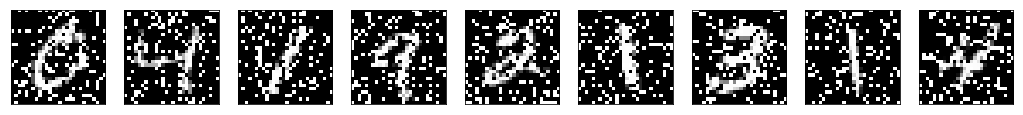

In [141]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

train_noisy = sp_noise(X, 0.15)
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(train_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [142]:
train_noisy = train_noisy[:, np.newaxis, :, :]
train_noisy = train_noisy/255
X = X / 255
autoencoder.fit(train_noisy, X, epochs=10, validation_split=0.1, batch_size=1024)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 79s 1ms/step - loss: 0.3802 - val_loss: 0.2640
Epoch 2/10
54000/54000 [==============================] - 80s 1ms/step - loss: 0.2598 - val_loss: 0.2564
Epoch 3/10
54000/54000 [==============================] - 79s 1ms/step - loss: 0.2536 - val_loss: 0.2487
Epoch 4/10
54000/54000 [==============================] - 78s 1ms/step - loss: 0.2402 - val_loss: 0.2302
Epoch 5/10
54000/54000 [==============================] - 77s 1ms/step - loss: 0.2209 - val_loss: 0.2108
Epoch 6/10
54000/54000 [==============================] - 81s 2ms/step - loss: 0.2015 - val_loss: 0.1938
Epoch 7/10
54000/54000 [==============================] - 79s 1ms/step - loss: 0.1888 - val_loss: 0.1852
Epoch 8/10
54000/54000 [==============================] - 77s 1ms/step - loss: 0.1817 - val_loss: 0.1790
Epoch 9/10
54000/54000 [==============================] - 79s 1ms/step - loss: 0.1763 - val_loss: 0.1744
Epoch 

In [148]:
autoencoder.fit(train_noisy, X, epochs=3, validation_split=0.1, batch_size=1024)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 79s 1ms/step - loss: 0.1535 - val_loss: 0.1535
Epoch 2/3
54000/54000 [==============================] - 85s 2ms/step - loss: 0.1523 - val_loss: 0.1519
Epoch 3/3
54000/54000 [==============================] - 82s 2ms/step - loss: 0.1509 - val_loss: 0.1511


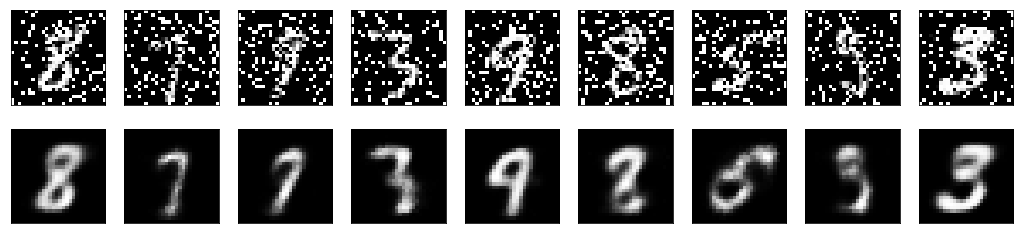

In [167]:
a = autoencoder.predict(train_noisy[40:90])
plt.figure(figsize=(20, 4))
for i in range(1, 10):
    ax = plt.subplot(2, n, i)
    plt.imshow(train_noisy[i+40, -1, :, :])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+n)
    plt.imshow(a[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()